<a href="https://colab.research.google.com/github/oakhtar147/global-wheat-detection-yolov5/blob/master/custom_wheat_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Clone repo, install dependencies, `%cd` into `./yolov5` folder and check GPU.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [ ]:
!nvidia-smi

Fri Sep 18 05:47:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Kaggle Global Wheat Detection

This Colab notebook contains my work by using a YOLOv5 Object detection problem to solve the [Global Wheat Detection problem](https://www.kaggle.com/c/global-wheat-detection). Here we use an algorithm called YOLO (v5).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing dependencies:



In [ ]:
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm_notebook

%matplotlib inline

## Data pre-processing

We now import the data from mounted Google Drive. After that we analyse the data and the format it is available in. After understanding the format of data needed to train YOLO, we start munging data to achieve the format needed.

In [ ]:
DATA_PATH = "/content/drive/My Drive/Kaggle/data"

df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [ ]:
print(df.source.unique()) 

['usask_1' 'arvalis_1' 'inrae_1' 'ethz_1' 'arvalis_3' 'rres_1' 'arvalis_2']


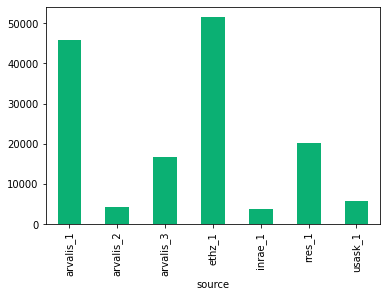

In [ ]:
sources_dist = df.groupby("source")["image_id"].count()
sources_dist.plot(kind="bar", color="#0bb073")

# this plot shows the source dist from of train images
# from different institutions

In [ ]:
df.drop(columns=["width", "height", "source"], inplace=True) # unimportant column alongside width and height columns
df.tail() # for each img we have n bboxes where n is approx. the no. of wheatheads in img

image_id                         bbox
147788  5e0747034    [64.0, 619.0, 84.0, 95.0]
147789  5e0747034  [292.0, 549.0, 107.0, 82.0]
147790  5e0747034  [134.0, 228.0, 141.0, 71.0]
147791  5e0747034   [430.0, 13.0, 184.0, 79.0]
147792  5e0747034   [875.0, 740.0, 94.0, 61.0]

In [ ]:
# both the columns are strings, we need bboxes in list type
type(df["image_id"][0]), type(df["bbox"][0])

(str, str)

In [ ]:
list_bboxes = df["bbox"].apply(ast.literal_eval)

In [ ]:
df["bbox"] = list_bboxes

In [ ]:
print(type(df["bbox"][0]))
df.head()

<class 'list'>


image_id                         bbox
0  b6ab77fd7   [834.0, 222.0, 56.0, 36.0]
1  b6ab77fd7  [226.0, 548.0, 130.0, 58.0]
2  b6ab77fd7  [377.0, 504.0, 74.0, 160.0]
3  b6ab77fd7  [834.0, 95.0, 109.0, 107.0]
4  b6ab77fd7  [26.0, 144.0, 124.0, 117.0]

In [ ]:
g_imageID = df.groupby("image_id")

def img_sanity_check():
  random_img_index = np.random.randint(0, len(os.listdir(os.path.join(DATA_PATH, "train"))))
  i = 0
  for img_id, img_id_df in g_imageID:
    if i == random_img_index:
      print(f"IMAGE_ID: {img_id}\n")
      print(f"The number of bounding boxes in this image is: {img_id_df.size // 2}")
      plt.imshow(Image.open(f"{DATA_PATH}/train/{img_id}.jpg"))
      plt.axis("off")
      break
    else: 
      i += 1 

IMAGE_ID: af35871fc

The number of bounding boxes in this image is: 71


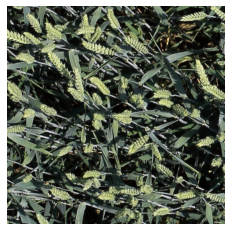

In [ ]:
img_sanity_check()

Our data is now in the format we suitable for the algorithm to train on. For each image under the column `image_id` we have a list of lists under the column `bbox`. Each `list` in this `list` represents the annotation (coordinates) for one bounding box (`[x_center, y_center, w, h]`) in that image.

In [ ]:
df = g_imageID["bbox"].apply(list).reset_index()
df.head()

image_id                                               bbox
0  00333207f  [[0, 654, 37, 111], [0, 817, 135, 98], [0, 192...
1  005b0d8bb  [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...
2  006a994f7  [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...
3  00764ad5d  [[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1...
4  00b5fefed  [[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1...

We split the data in 80% 20% train/val split. We have also set `random_state=42` for reproducible results for comparison later.

In [ ]:
df_train, df_val = train_test_split(df, 
                                    train_size=0.8, 
                                    random_state=42,
                                    shuffle=True)

print("The number of images in train set is:", df_train.shape[0])
print("The number of images in validation set is:", df_val.shape[0])

The number of images in train set is: 2698
The number of images in validation set is: 675


# Creating the directory tree structure for training.

We needed a specific directory structure for our data so that it is suitable for training by the algorithm. Below function creates that structure. We have images and labels in the following form:


*   wheat_data
  *   images
      *   train
      *   val

*   wheat_data
  *   labels
      *   train
      *   val


In the `train`/`val` directories under `images` contain images for which there are corresponding annotations in `labels` directory. 







In [ ]:
OUTPUT_PATH = "/content/drive/My Drive/wheat_data"

def process_data(data, data_type="train"):
    for _, row in tqdm_notebook(data.iterrows(), total=len(data)):
        image_ID = row["image_id"]
        bboxes = []
        for bbox in row["bbox"]:
            x = bbox[0]
            y = bbox[1]
            w = bbox[2]
            h = bbox[3]
            x_center = (x + w/2) / 1024
            y_center = (y + h/2) / 1024
            w /= 1024
            h /= 1024
            bboxes.append([0, x_center, y_center, w, h])
        bboxes_array = np.array(bboxes)
        np.savetxt(f"{OUTPUT_PATH}/labels/{data_type}/{image_ID}.txt", bboxes_array, fmt=["%d", "%f", "%f", "%f", "%f"])
        shutil.copy(f"{DATA_PATH}/train/{image_ID}.jpg", f"{OUTPUT_PATH}/images/{data_type}/{image_ID}.jpg")

In [ ]:
# process_data(df_train, data_type="train")

In [ ]:
# process_data(df_val, data_type="val")

In [ ]:
len(os.listdir(OUTPUT_PATH+"/images/train")), len(os.listdir(OUTPUT_PATH+"/images/val"))
# so we have properly processed the data

(2698, 675)

In [ ]:
%pwd
%cd yolov5

/content/yolov5


# Training

After data-preprocessing and annotations. We start training the model. We have trained the smallest model `yolo5s` which took approximately 0.4 hrs for 2 epochs training. I have trained the model for 12 epochs.


In [ ]:
# !python train.py --img 1024 --batch 8 --epochs 2 --data "/content/drive/My Drive/Kaggle/wheat.yaml" --cfg ./models/yolov5s.yaml --weights "/content/drive/My Drive/runs/runs/exp2/weights/best.pt"

Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Namespace(adam=False, batch_size=8, bucket='', cache_images=False, cfg='./models/yolov5s.yaml', data='/content/drive/My Drive/Kaggle/wheat.yaml', device='', epochs=2, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[1024, 1024], local_rank=-1, logdir='runs/', multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=8, weights='/content/drive/My Drive/runs/runs/exp2/weights/best.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-09-15 07:17:30.469472: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8,

In [ ]:
# !rm -r "/content/drive/My Drive/runs/runs/exp0"
# !rm -r "/content/drive/My Drive/runs/runs/exp1"
# !mv "/content/drive/My Drive/runs/runs/exp2" "/content/drive/My Drive/runs/runs/exp0"
# !mv "/content/yolov5/runs/exp3" "/content/drive/My Drive/runs/runs/exp1"

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "/content/drive/My Drive/runs/runs"

In [ ]:
RUNS = "/content/drive/My Drive/runs/runs"

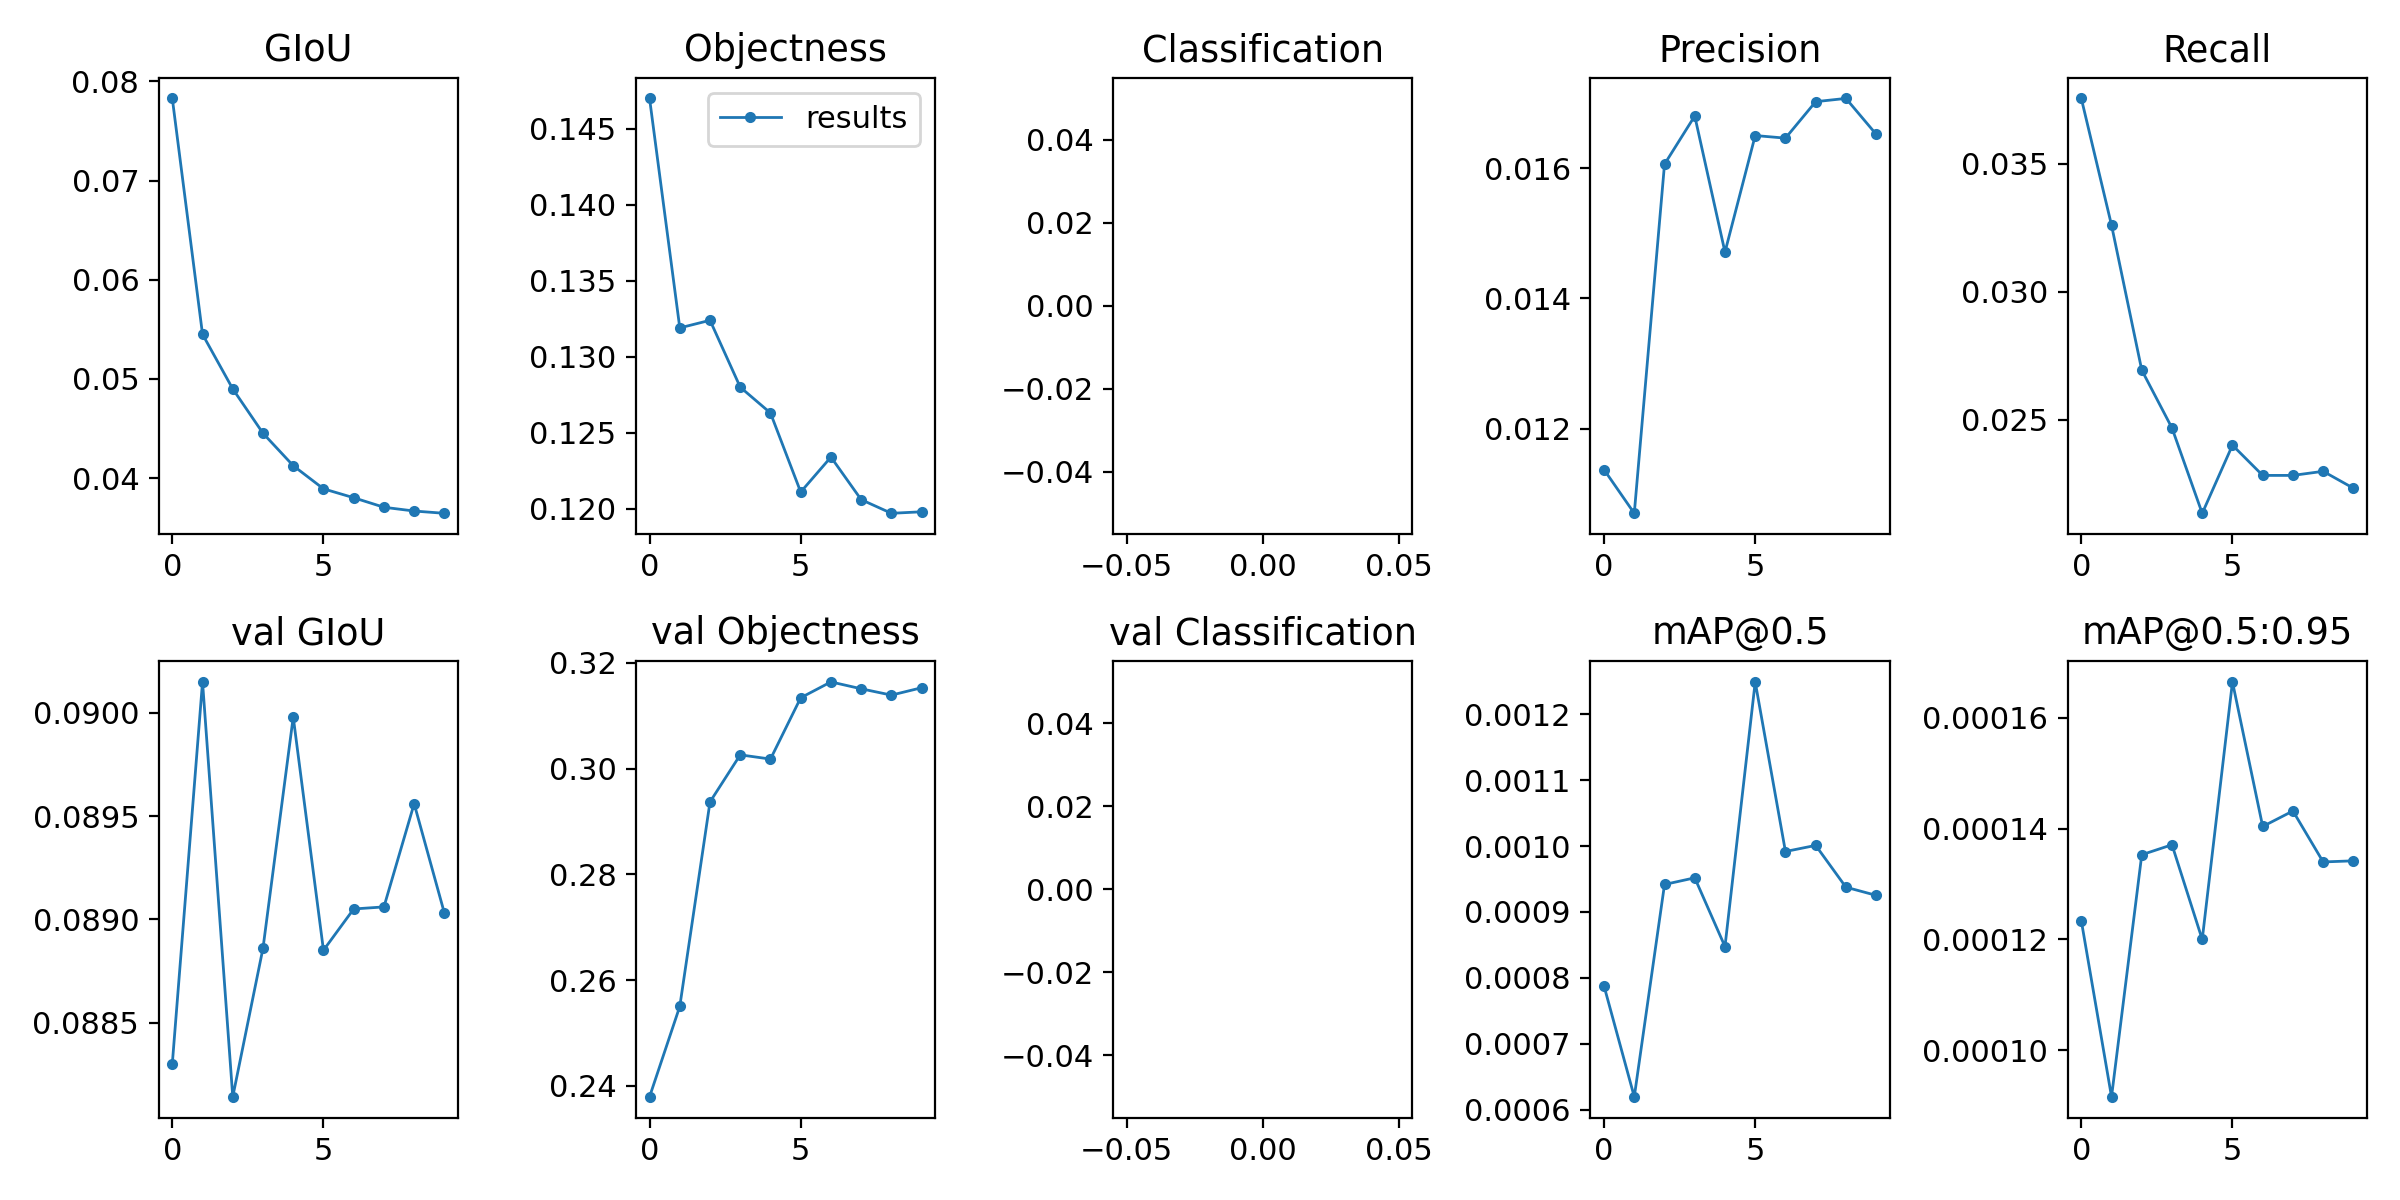

In [ ]:
from IPython.display import Image, display

Image(os.path.join(RUNS, "exp0/results.png"))

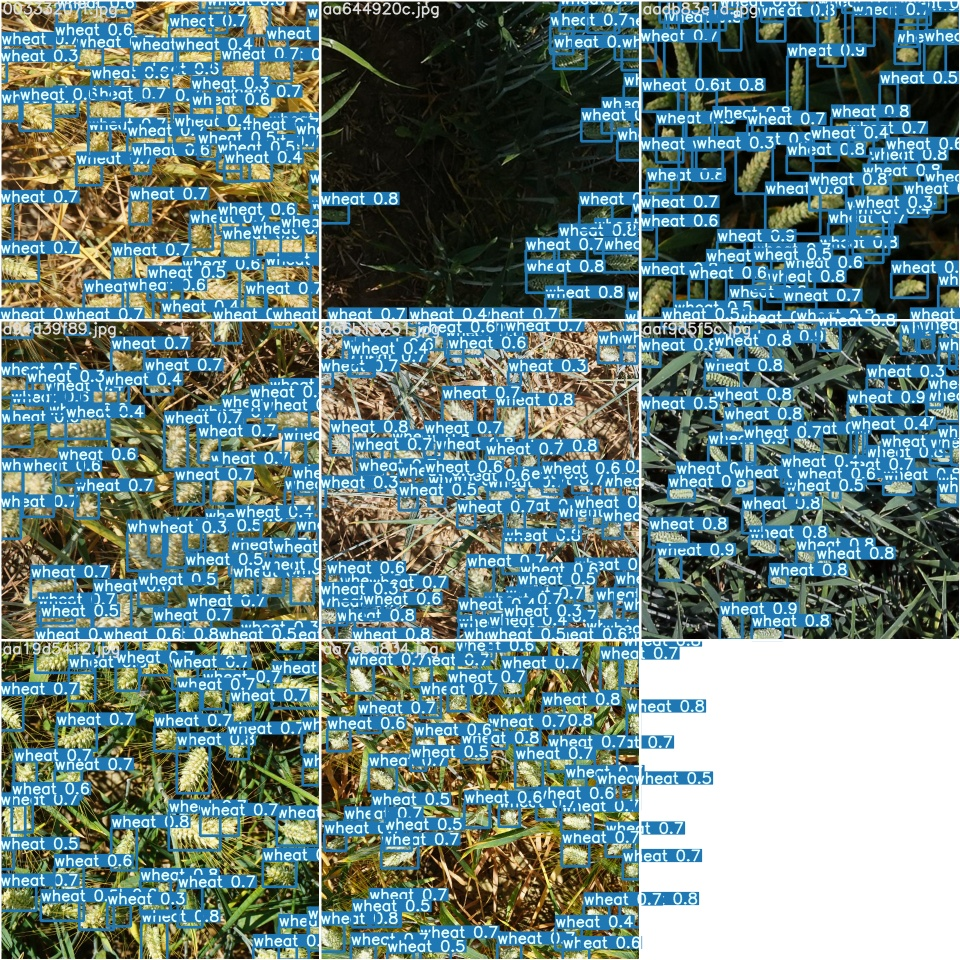

In [ ]:
Image(os.path.join(RUNS,"exp0/test_batch0_pred.jpg"))

In [ ]:
# !cp -r "runs" "/content/drive/My Drive/runs" # runs contains the weights for our trained model too

# Running Inferences 

We ran inferences and saved the image and corresponding annotations file in drive. We set the `--iou-thres = 0.7` because in our images, we noticed that some wheatheads were very close to each other and were detected as one wheathead. So by increasing this threshold from `0.5` to `0.7` we noticed that the inference became better. Though increasing it to `0.8` resulted in excess bounding boxes since they were not being removed by non-max suppression.

In [ ]:
!python detect.py --source "/content/drive/My Drive/Kaggle/data/test" --img-size 1024 --output "/content/drive/My Drive/Kaggle/inferences" --weights "/content/drive/My Drive/runs/runs/exp1/weights/best.pt" --conf-thres 0.3 --iou-thres 0.7 --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.3, device='', img_size=1024, iou_thres=0.7, output='/content/drive/My Drive/Kaggle/inferences', save_txt=True, source='/content/drive/My Drive/Kaggle/data/test', update=False, view_img=False, weights=['/content/drive/My Drive/runs/runs/exp1/weights/best.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Fusing layers... 
Model Summary: 140 layers, 7.24652e+06 parameters, 6.61683e+06 gradients
image 1/10 /content/drive/My Drive/Kaggle/data/test/2fd875eaa.jpg: 1024x1024 29 ws, Done. (0.072s)
image 2/10 /content/drive/My Drive/Kaggle/data/test/348a992bb.jpg: 1024x1024 35 ws, Done. (0.071s)
image 3/10 /content/drive/My Drive/Kaggle/data/test/51b3e36ab.jpg: 1024x1024 26 ws, Done. (0.072s)
image 4/10 /content/drive/My Drive/Kaggle/data/test/51f1be19e.jpg: 1024x1024 18 ws, Done. (0.072s)
image 5/10 /content/drive/My Drive/Kaggle/data/test/53f253011.jpg: 1024x1024 32 ws, Done. (0.072s)


In [ ]:
# !cp -r "inference/output" "/content/drive/My Drive/Kaggle"

Displaying the final inferences and analyzing them.


IMAGE: 2fd875eaa.jpg


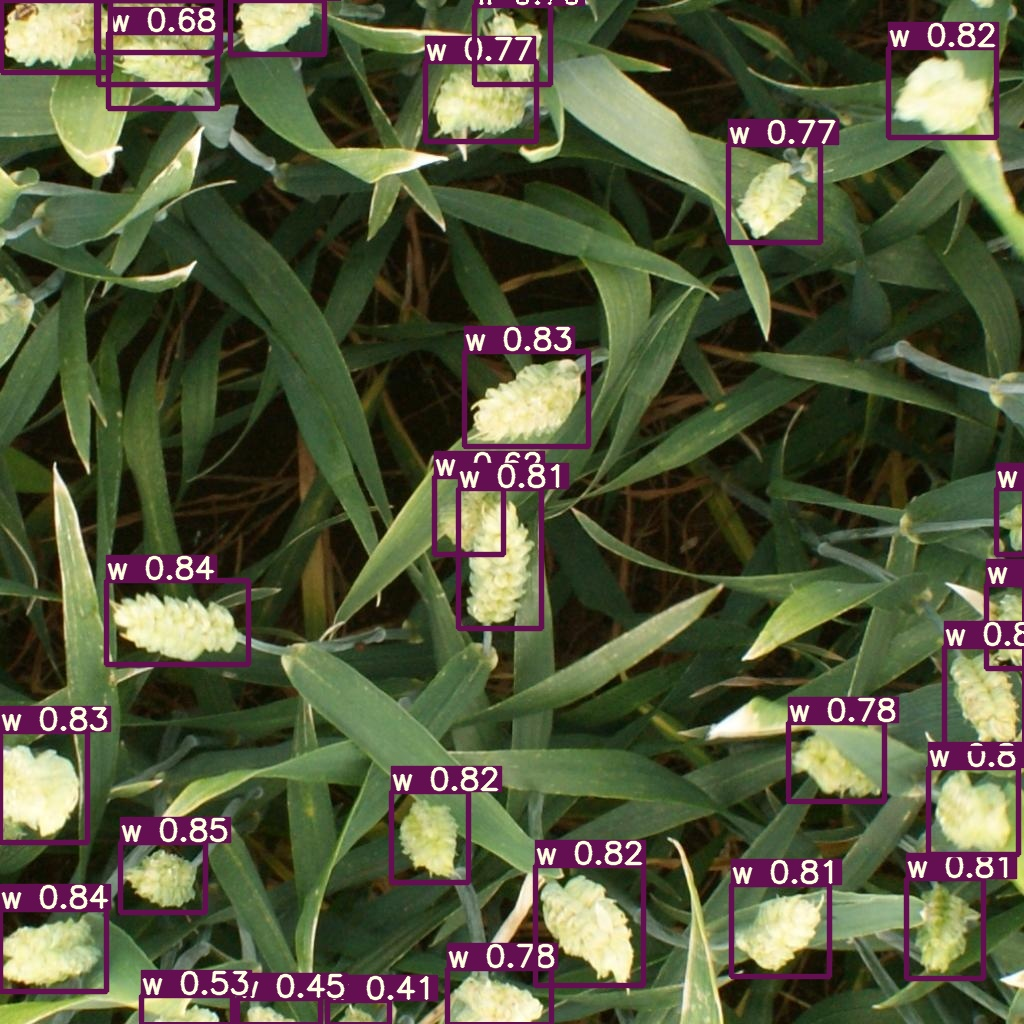


IMAGE: 348a992bb.jpg


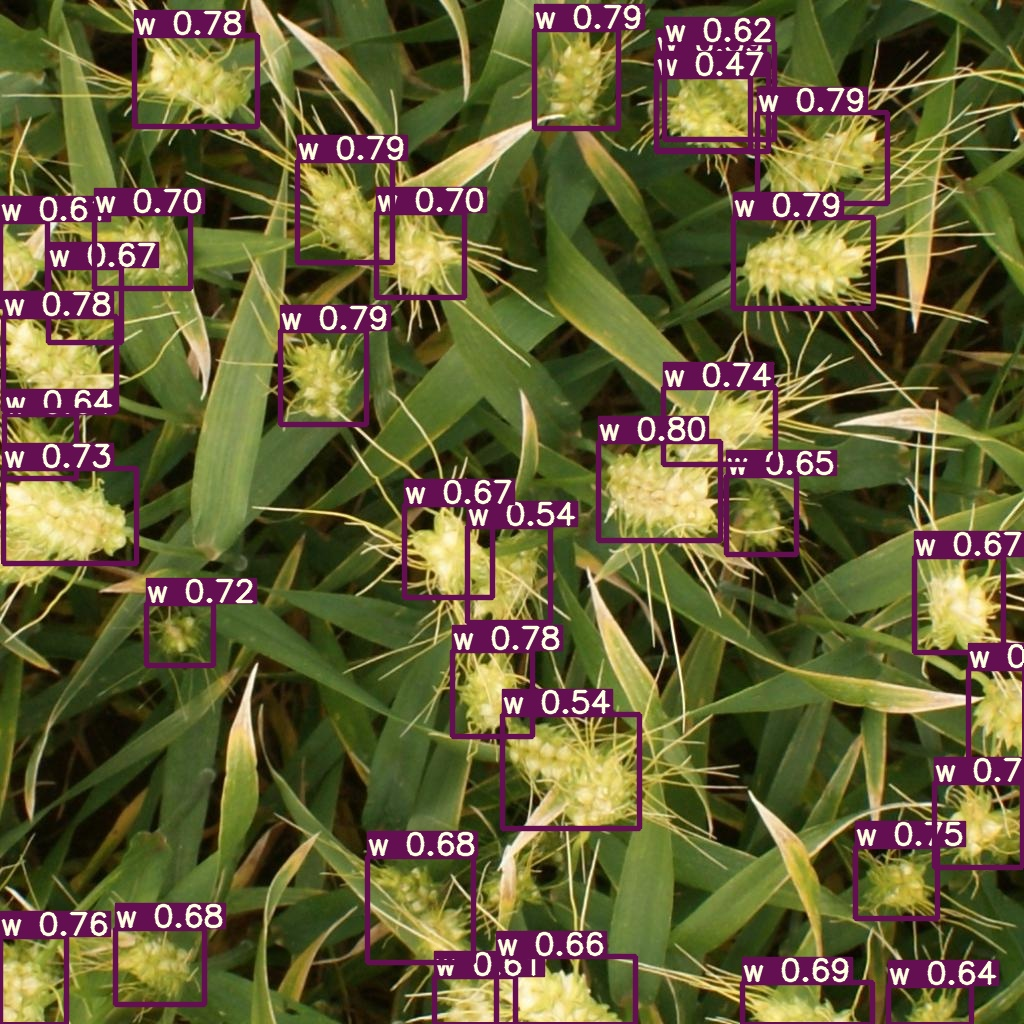


IMAGE: 51b3e36ab.jpg


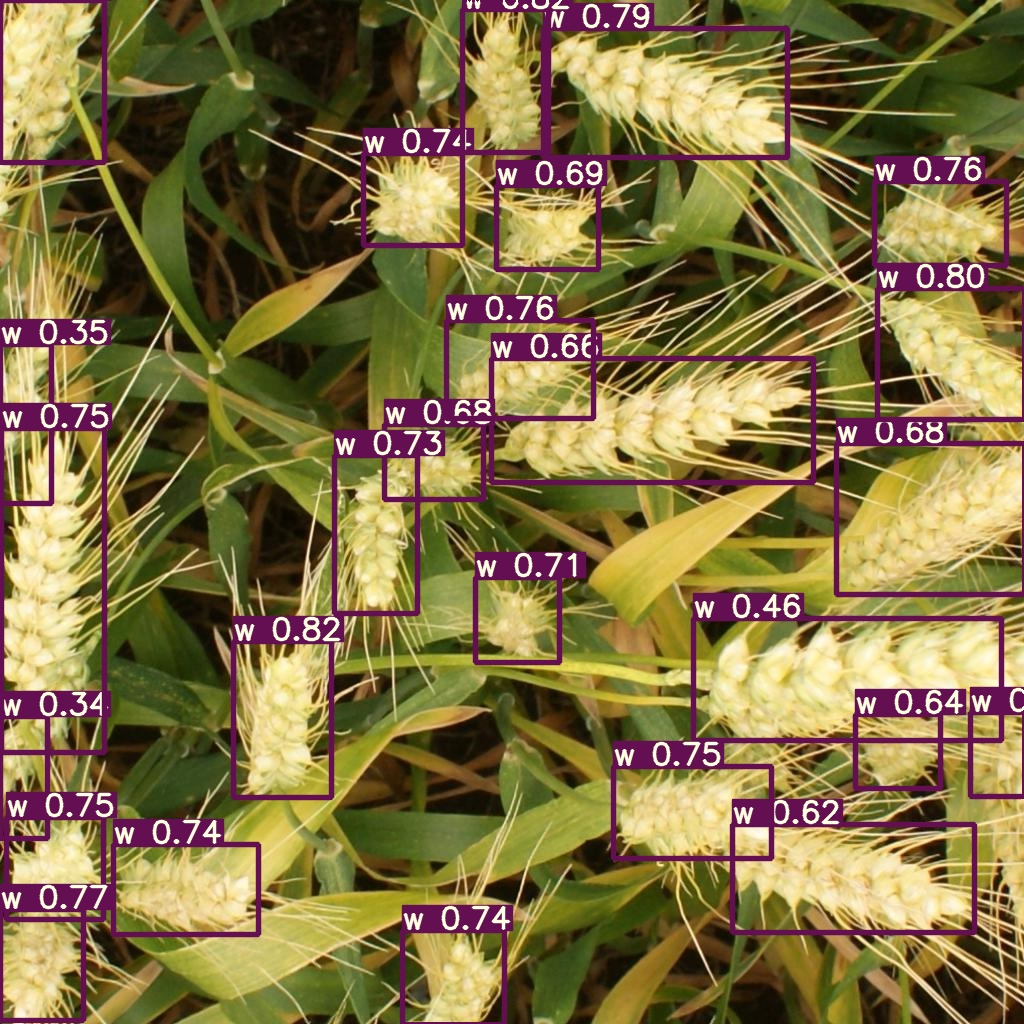


IMAGE: 51f1be19e.jpg


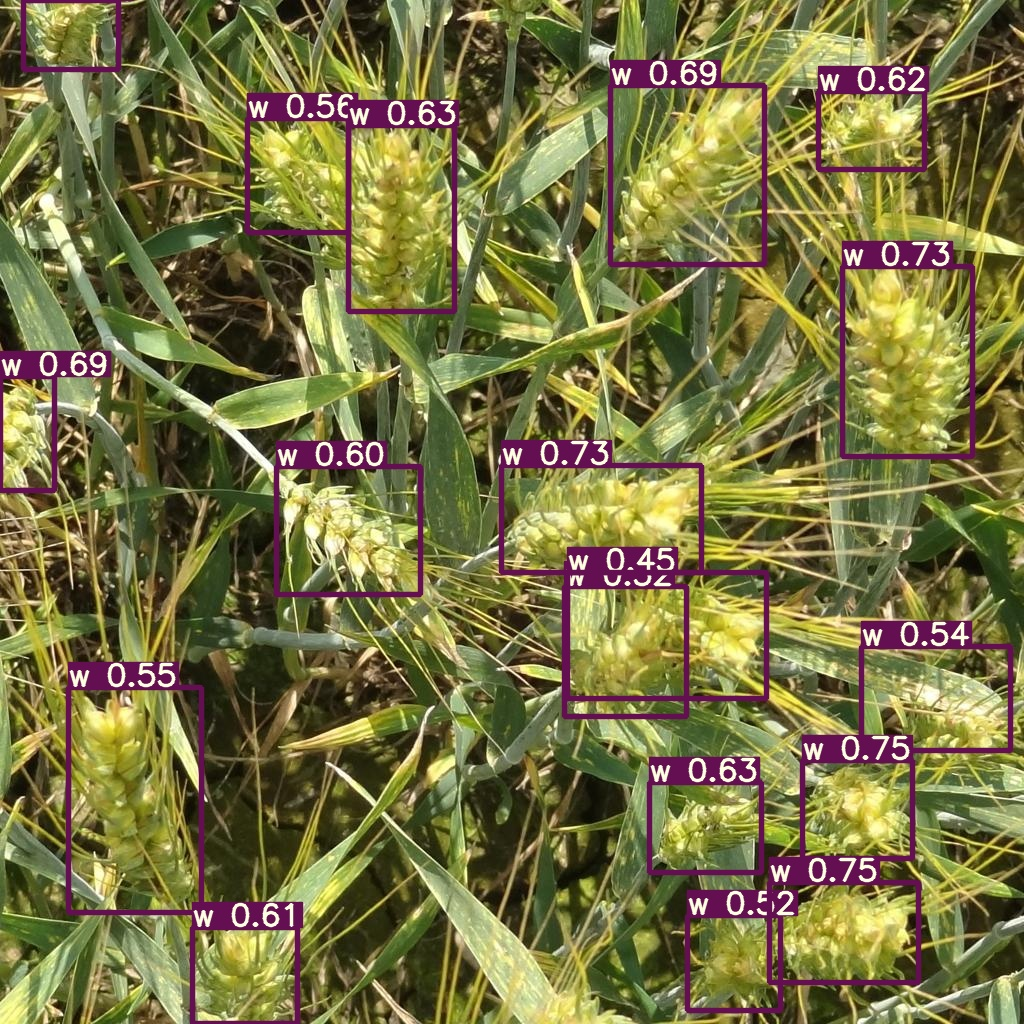


IMAGE: 53f253011.jpg


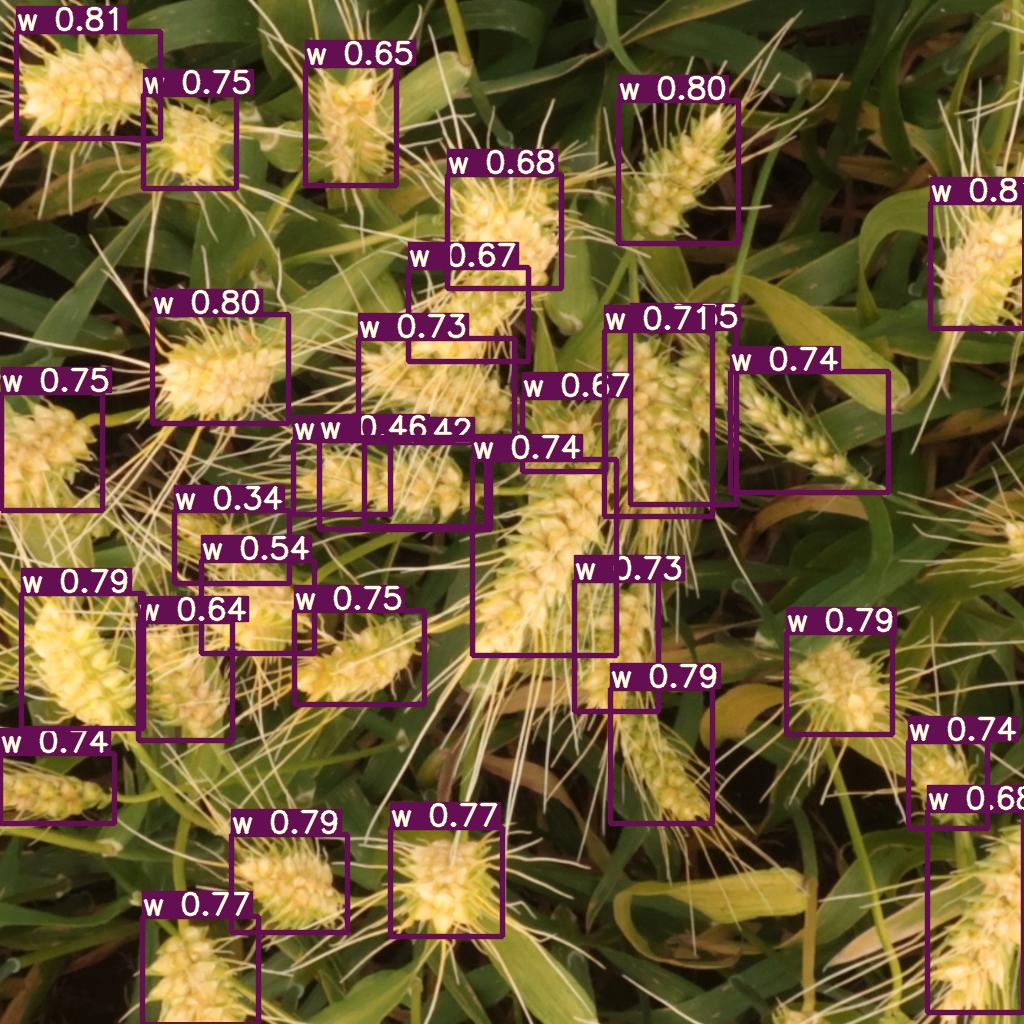


IMAGE: 796707dd7.jpg


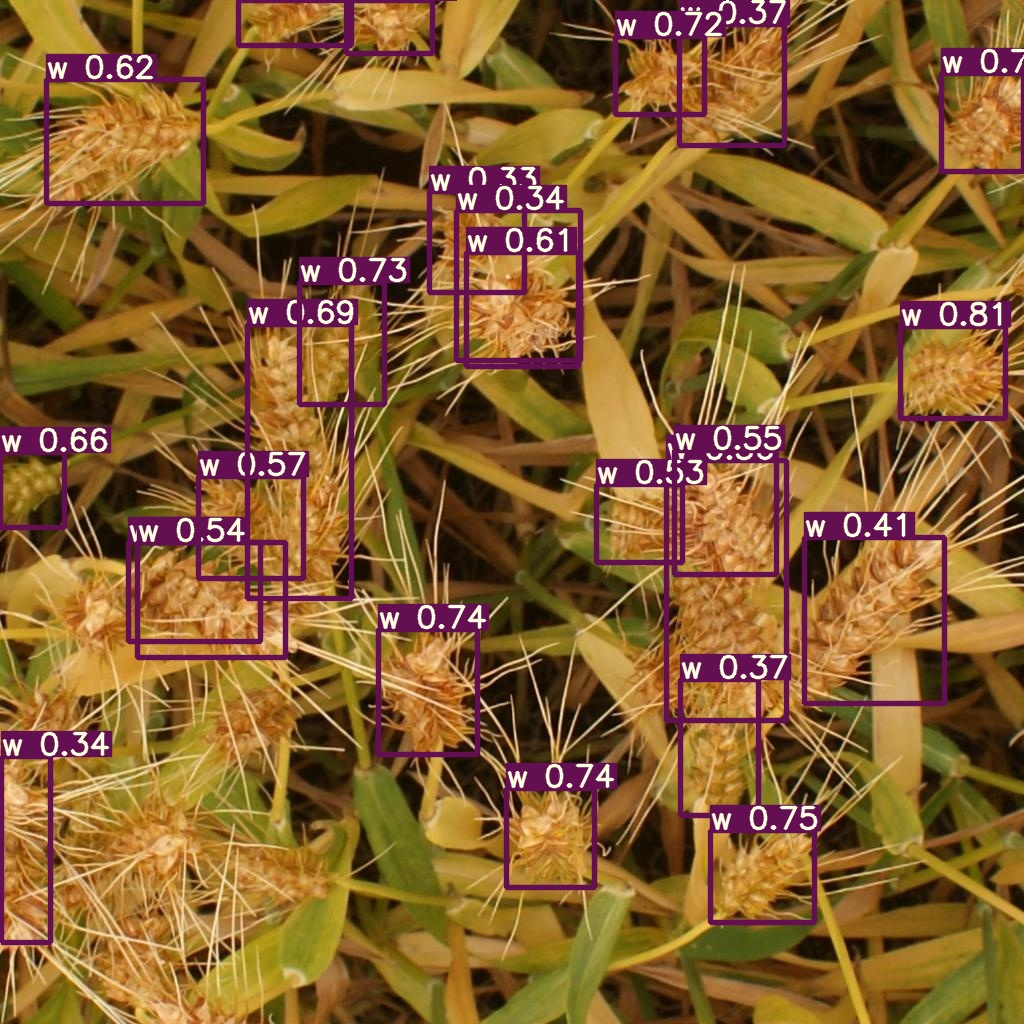


IMAGE: aac893a91.jpg


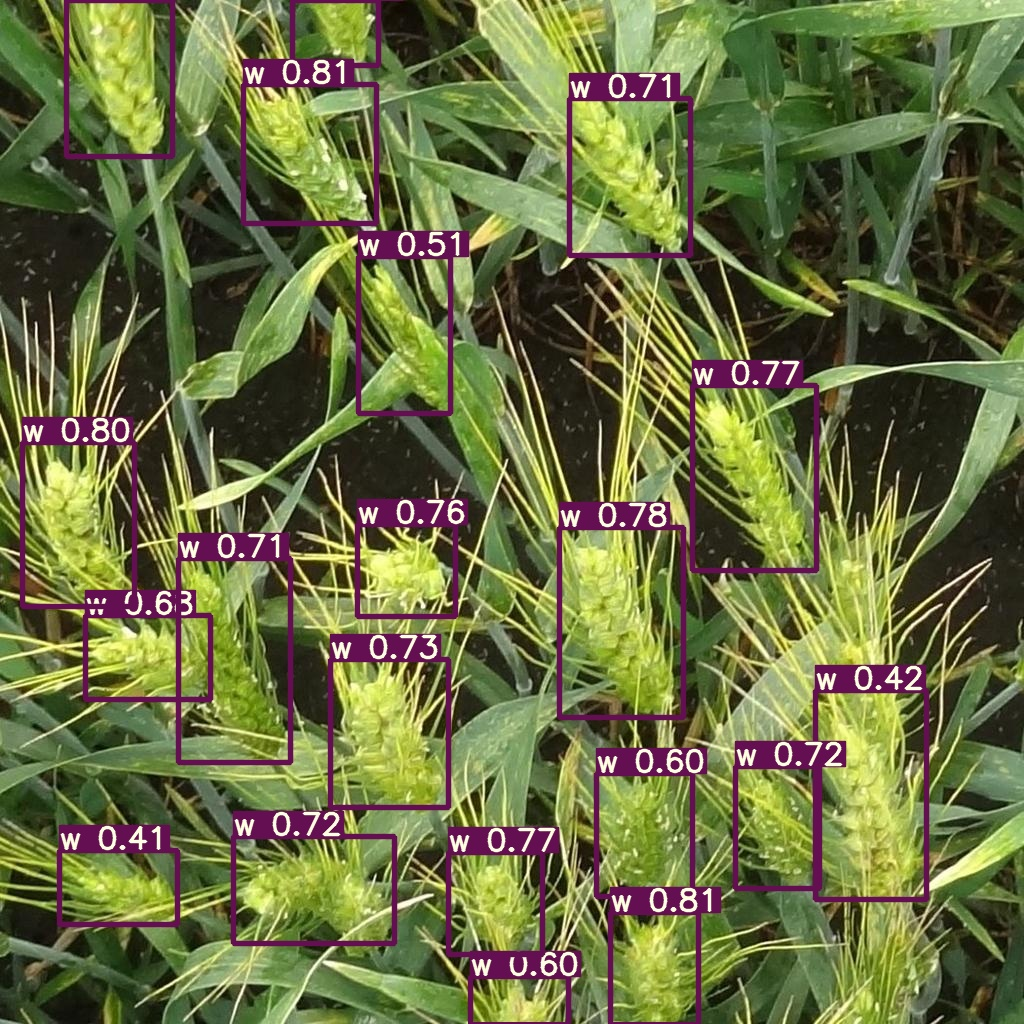


IMAGE: cb8d261a3.jpg


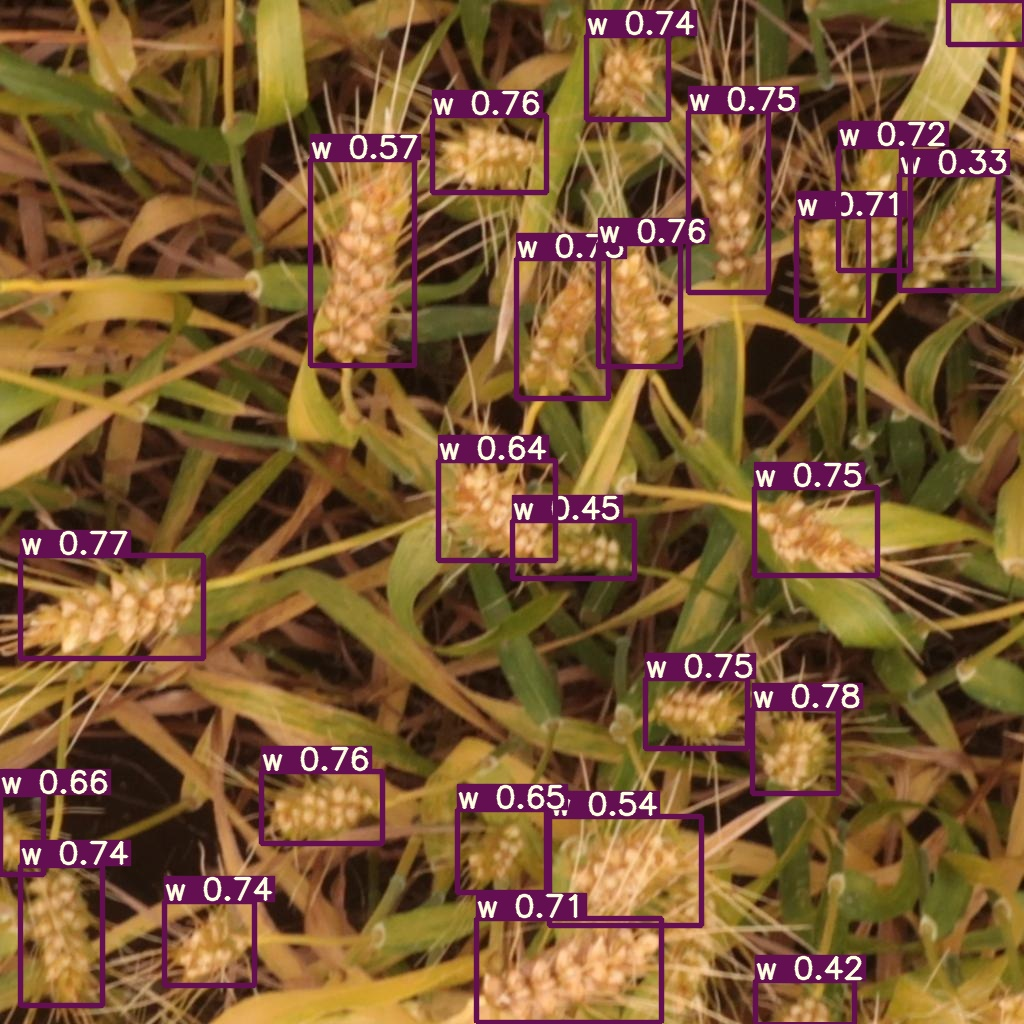


IMAGE: cc3532ff6.jpg


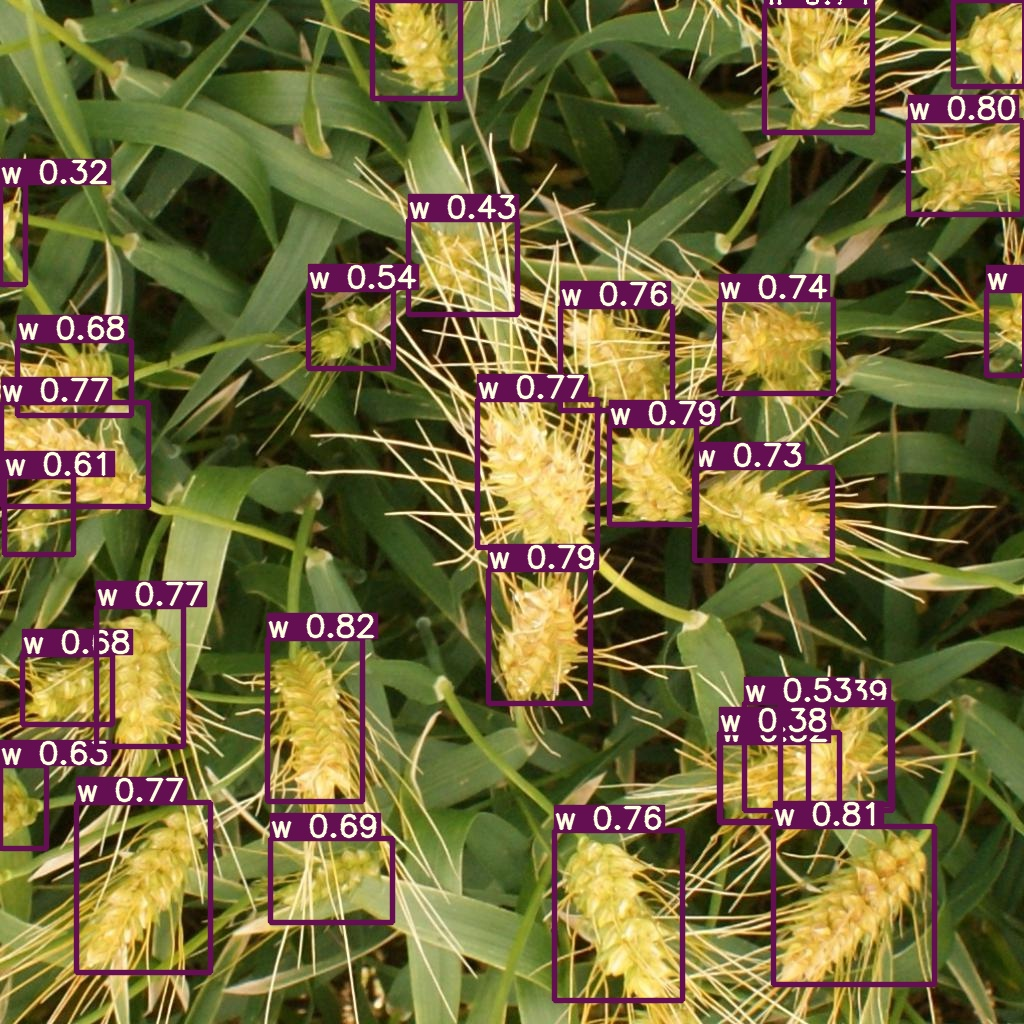


IMAGE: f5a1f0358.jpg


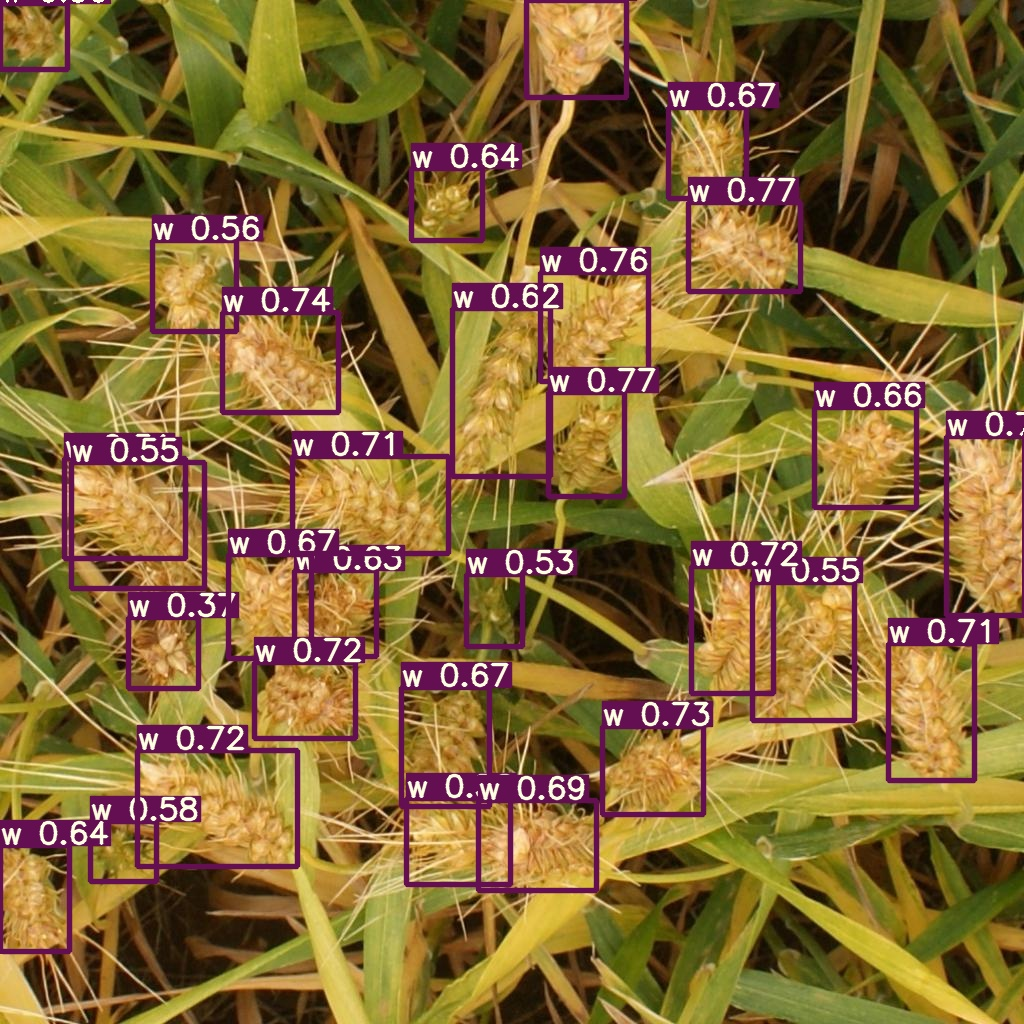

In [ ]:
from IPython.display import Image, display
INFERENCES = "/content/drive/My Drive/Kaggle/inferences"

def show_inferences(path_to_inferences):
  for image in os.listdir(path_to_inferences):
    if image.endswith(".jpg"):
      print(f"\nIMAGE: {image}")
      img = Image(os.path.join(path_to_inferences, image), width=400, height=400)
      display(img)

show_inferences(INFERENCES)      

# Appendix:

Here, I have created the expected submission `csv` file according to format required by the [competition](https://www.kaggle.com/c/global-wheat-detection). 

In [ ]:
def get_annotations(path_to_inferences):
  all_annotations = []

  for ann in os.listdir(path_to_inferences):
    if ann.endswith(".txt"):
      with open(os.path.join(path_to_inferences, ann), "r") as annotations:
        pred_string = " ".join([(lambda an: an.strip(" \n"))(an) for an in annotations.readlines()])
        all_annotations.append(pred_string)

  return all_annotations    

In [ ]:
annotations = [an.strip(".txt") for an in os.listdir(INFERENCES) if an.endswith(".txt")]
data = {"image_id": annotations, "PredictionString":  get_annotations(INFERENCES)}

submission = pd.DataFrame(data)
submission.head()

image_id                                   PredictionString
0  2fd875eaa  0.407471 358 1012 62 24 0.44458 1010 521 28 66...
1  348a992bb  0.393799 712 102.5 112 97 0.474609 703 113 94 ...
2  51b3e36ab  0.337646 23.5 777 47 122 0.351562 25.5 423.5 5...
3  51f1be19e  0.315918 625 651 122 130 0.445557 666.5 635 19...
4  53f253011  0.310547 341.5 477 97 74 0.338135 231.5 546.5 ...

In [ ]:
submission.to_csv("first_submission.csv")